In [ ]:
 """
 NOTE: For TPU only
 Must go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python
 """
 #! pip install cloud-tpu-client==0.10.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

'\nNOTE: For TPU only\nMust go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python\n'

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.2 MB/s eta 0:00:00


In [ ]:
# install tools for pulling Supreme Court Arguments transcripts 
# !pip3 install convokit
# !python3 -m spacy download en_core_web_sm

In [ ]:

import pandas as pd


# Rather than load Corpus, we load the transcripts csv separately 
# from convokit import Corpus, download
# import nltk

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#import torch_xla.core.xla_model as xm

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import BigBirdModel, BigBirdTokenizerFast
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
#device = xm.xla_device()

#check is gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('gpu available')
else:
    device = torch.device('cpu')
    print('gpu not available')

gpu available


Our first attempt involved creating full transcripts for each case and exporting them as CSVs, which we then loaded into the script as needed. This exceeded the memory limits of Google Colab's TPUs and GPUs during training. 

We then tried a similar process but with the the "utterance" transcripts -- essentially lengths of text spoken by one person. Here, however, the RAM limit was exceeded when using the package that creates the utterance objects. We do not know why the RAM was exceeded here given that we were able to run the package locally on machines with lower amounts of RAM. 

Our third attempt was to create a dataframe of all utterances and the associated text and export it as a csv, roughly 1.7 million lines and 0.6GB as opposed to the packages ~7.3GB. 

In [ ]:
# set to run with utterances or conversations 
utts = False

In [ ]:
# create dataframe of utterances by case
df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')

# create dataframe by conversation record
df_convo = pd.read_csv('/content/drive/MyDrive/INFO251Final/Outcomes_NoTranscript.csv')

# create dataframe of Martin Quinn scores to merge with dataframes
martin_quinn = pd.read_csv('/content/drive/MyDrive/INFO251Final/MartinQuinnScores.csv')

<ipython-input-62-81bd520b1b86>:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')


In [ ]:
def clean_utts(df_utt):
    # updating columns

    # rename columns
    df_utt = df_utt.rename(columns={'meta.votes_side': 'votes_side',
                                      'meta.win_side': 'win_side',
                                      'meta.case_id': 'case_id',
                                      'med': 'mq_score', 
                                      'conversation_id': 'convo_id',
                                      'term_year': 'term'})

    df_utt.term = df_utt.term.astype('int64')

    # add MartinQuinn Scores
    df_utt = df_utt.merge(martin_quinn[['term', 'med']], on='term')

    # drop unused columns
    # NOTE we may want to try an analysis on some of these later on
    df_utt = df_utt.drop(columns=['speaker', 
                                  'reply_to', 
                                  'timestamp', 
                                  'meta.start_times', 
                                  'meta.stop_times', 
                                  'meta.speaker_type',
                                  'meta.side',
                                  'meta.timestamp',
                                  'vectors',
                                  'Unnamed: 0'])


    # add "win_side" to utterance dataframe
    df_utt = df_utt.merge(df_convo[['convo_id', 'win_side']], on='convo_id')

    #df_utt.drop(columns=['Unnamed: 0'])
    df_utt = df_utt.rename(columns={'text': 'words'})

    # Remove instances where case outcome was unknown or ????
    df_utt.drop(df_utt[df_utt['win_side'] == -1.0].index, inplace = True)
    df_utt.drop(df_utt[df_utt['win_side'] == 2.0].index, inplace = True)

    # Remove null values from the few cases with incomplete data
    df_utt = df_utt.dropna()

    return df_utt

In [ ]:
df_utt = clean_utts(df_utt)

In [ ]:
def clean_convos(df_convo):
  # Remove instances where case outcome was unknown or ????
  df_convo.drop(df_convo[df_convo['win_side'] == -1.0].index, inplace = True)
  df_convo.drop(df_convo[df_convo['win_side'] == 2.0].index, inplace = True)

  # convert term from object to int
  df_convo.term = df_convo.term.astype('int64')

  # drop unused columns
  # NOTE we may want to try an analysis on some of these later on. Save memory now
  df_convo = df_convo.drop(columns=['Unnamed: 0', 'vectors', 'advocates', 'votes_side'])

  # 3 cases have null data due to oddities of transcribing data pre-digital transcripts
  df_convo = df_convo.dropna()

  return df_convo

In [ ]:
df_convo = clean_convos(df_convo)

In [ ]:
df_test = df_convo.sample(n=600, replace=False, random_state=123)

In [ ]:
##### Delete for now
del(df_utt)

In [ ]:
# pull transcripts for each utterance or conversation and store in "words" column
# This method separately creates the transcripts for each conversation and stores them in a 
# separate folder for reference. Although this allowed for easy grouping by case, it 
# overwhelmed memory allocations 

def add_transcripts(df_test, n=1000, utts=False):
  for index, row in df_test.iterrows():


    if utts:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_uttid_caseid/'
      read_path = folder_path+str(row['utt_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = text[:n]
      df_test.loc[index, 'words'] = text

      transcript.close()

    else:
      folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_Case_Convo/'
      read_path = folder_path+str(row['convo_id'])+'_'+str(row['case_id'])+'.txt'

      transcript = open(read_path, 'r')
      text = transcript.read()

      text = text[:n]

      df_test.at[index, 'words'] = text
  
      transcript.close()

  return df_test
    

In [ ]:
df_test = add_transcripts(df_test)

In [ ]:
# convert to int for later reference by language models 
df_test['win_side'] = df_test['win_side'].astype(int)

In [ ]:
df_test.head()

,case_id,win_side,convo_id,term,docket_id,mq_score,words
1037,1960_257,1,14377,1960,257,0.443,"-- Chief Justice, members of the Court.\nBefor..."
1569,1963_615,1,14192,1963,615,-1.133,"Number 615, Escobedo, Petitioner, versus Illin..."
1591,1963_116,0,14748,1963,116,-1.133,-- Hostetter versus Idlewild Bon Voyage Liquor...
7352,2012_10-930,1,23571,2012,10-930,0.24,We'll hear argument first this morning in Case...
4413,1982_81-1020,1,19321,1982,81-1020,0.673,We will hear arguments first this morning in E...


In [ ]:
import gc
gc.collect()

156

In [ ]:
#### ONLY FOR UTTERANCES
# Run train test split with conversation grouping 

if utts:
  gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

In [ ]:
# create train and temp split. Temp split will be split in half into testing and validation sets
for train_idx, test_idx in gss.split(df_test, groups=df_test['convo_id']):
    train_df = df_test.iloc[train_idx]
    temp_df = df_test.iloc[test_idx]

NameError: ignored

In [ ]:
# split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_test['words'], 
                                                                    df_test['win_side'], 
                                                                    random_state=123, 
                                                                    test_size=0.3)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, 
                                                                temp_labels, 
                                                                random_state=123, 
                                                                test_size=0.5)

In [ ]:
%who

AdamW	 AutoModel	 AutoModelForSequenceClassification	 AutoTokenizer	 BERT_Arch	 BertTokenizerFast	 BigBirdModel	 BigBirdTokenizerFast	 DataLoader	 
GroupShuffleSplit	 RandomSampler	 SequentialSampler	 TensorDataset	 add_transcripts	 batch_size	 best_valid_loss	 bigbird	 class_weights	 
classification_report	 clean_convos	 clean_utts	 compute_class_weight	 cross_entropy	 device	 df_convo	 df_test	 drive	 
epoch	 epochs	 evaluate	 gc	 martin_quinn	 nn	 np	 optimizer	 os	 
param	 path	 pd	 preds	 seq_len	 temp_labels	 temp_text	 test_labels	 test_mask	 
test_seq	 test_text	 test_y	 tokenizer	 tokens_test	 tokens_train	 tokens_val	 torch	 train	 
train_data	 train_dataloader	 train_labels	 train_loss	 train_losses	 train_mask	 train_sampler	 train_seq	 train_test_split	 
train_text	 train_y	 transformers	 utts	 val_data	 val_dataloader	 val_labels	 val_mask	 val_sampler	 
val_seq	 val_text	 val_y	 valid_loss	 valid_losses	 weights	 


In [ ]:
# delete older dfs to free up memory 
del(df_convo, martin_quinn)

In [ ]:
gc.collect()

16

In [ ]:
########################
# BigBird Model
# Load the BigBird model
bigbird = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# Load the BigBird tokenizer
tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
#########################


#########################
# BERT base model
# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#########################


# #########################
# # DeBERTa v3 base model
# Deberta = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=2)

# # Load the DeBERTa v3 tokenizer
# tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base', model_max_length=512)
# #########################

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

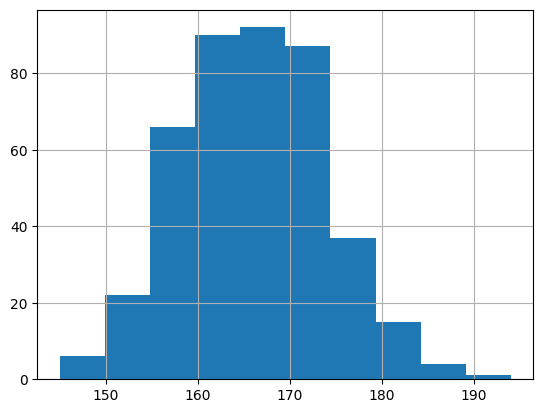

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist()

The below cells exceed Google's RAM limits. The code above attempts to split tokenization up

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters

#original
#for param in bigbird.parameters():
   # param.requires_grad = False
#myswitch
for param in bigbird.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bigbird):
        super(BERT_Arch, self).__init__()
        
        self.bigbird = bigbird 
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        outputs = self.bigbird(sent_id, attention_mask=mask, return_dict=True, output_hidden_states=True)
        
        cls_hs = outputs['hidden_states'][-1][:, 0]

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x


In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bigbird)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5, weight_decay=1e-3) 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# compute the class weights
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.51079137 0.74733096]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [ ]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 25 batches.
        if step % 25 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            #Issue here so I commented out
            #elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# import gc
gc.collect()

47

In [ ]:
# set initial loss to infinite
best_valid_loss = float('16')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5

Evaluating...

Training Loss: 0.701
Validation Loss: 0.703

 Epoch 2 / 5

Evaluating...

Training Loss: 0.701
Validation Loss: 0.701

 Epoch 3 / 5

Evaluating...

Training Loss: 0.708
Validation Loss: 0.699

 Epoch 4 / 5

Evaluating...

Training Loss: 0.699
Validation Loss: 0.698

 Epoch 5 / 5

Evaluating...

Training Loss: 0.694
Validation Loss: 0.697


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.43      0.95      0.59        37
           1       0.78      0.13      0.23        53

    accuracy                           0.47        90
   macro avg       0.60      0.54      0.41        90
weighted avg       0.64      0.47      0.38        90



In [ ]:
preds

In [ ]:
del(model)
torch.cuda.empty_cache()